In [1]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.3/519.3 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 10.4 MB/s eta 0:00:00


In [2]:
from datasets import load_dataset
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
np.random.seed(42)

In [3]:
dataset = load_dataset('tum-nlp/IDMGSP', 'classifier_input')

Generating train split:   0%|          | 0/16000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/8000 [00:00<?, ? examples/s]

In [4]:
import textwrap
def wrap_text(text, width = 100):
  return textwrap.fill(text, width=width)

In [5]:
def get_papers_text(example):
  return {"text": "Abstract:\n\n" + example["abstract"] + "\n\nIntroduction:\n\n" + example["introduction"] + "\n\nConclusion:\n\n" + example["conclusion"]}

In [6]:
dataset = dataset.map(get_papers_text)

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/8000 [00:00<?, ? examples/s]

In [7]:
X_train = dataset['train']['text']
y_train = dataset['train']['label']
X_test = dataset['test']['text']
y_test = dataset['test']['label']

bag of words

In [8]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

# Linguistic Characteristics

## readability

In [9]:
!pip install py-readability-metrics

In [10]:
from readability import Readability
from readability.exceptions  import ReadabilityException
import importlib
import re

In [11]:
dataset_ood_real = load_dataset('tum-nlp/IDMGSP', 'ood_real')
dataset_ood_real = dataset_ood_real.map(get_papers_text)
dataset_ood_real

Generating test split:   0%|          | 0/4000 [00:00<?, ? examples/s]

Map:   0%|          | 0/4000 [00:00<?, ? examples/s]

DatasetDict({
    test: Dataset({
        features: ['abstract', 'introduction', 'conclusion', 'src', 'label', 'text'],
        num_rows: 4000
    })
})

In [12]:
dataset_gpt3 = load_dataset('tum-nlp/IDMGSP', 'ood_gpt3')
dataset_gpt3 = dataset_gpt3.map(get_papers_text)
dataset_gpt3

Generating train split:   0%|          | 0/1200 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1200 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['title', 'abstract', 'introduction', 'conclusion', 'src', 'label', 'text'],
        num_rows: 1200
    })
    test: Dataset({
        features: ['title', 'abstract', 'introduction', 'conclusion', 'src', 'label', 'text'],
        num_rows: 1000
    })
})

In [13]:
dataset_cc = load_dataset('tum-nlp/IDMGSP', 'test-cc')
dataset_cc = dataset_cc.map(get_papers_text)
dataset_cc

Generating test split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/4000 [00:00<?, ? examples/s]

DatasetDict({
    test: Dataset({
        features: ['id', 'year', 'title', 'abstract', 'introduction', 'conclusion', 'categories', 'src', 'paraphrased_sections', 'label', 'text'],
        num_rows: 4000
    })
})

In [14]:
def readability_scores(text, readability_scores = ['flesch_kincaid', 'flesch', 'gunning_fog', 'coleman_liau', 'dale_chall', 'ari', 'linsear_write', 'spache'], print_text = True, print_score = True):
  ret = []
  if print_text:
    print("Text:")
    # Wrap the text to the specified width
    wrapped_text = wrap_text(text)
    print(wrapped_text)
  if print_score:
    print("Scores:")
  r = Readability(text)
  for score in readability_scores:
    score_value = getattr(r, score)()
    ret.append(score_value)
    if print_score:
      print(f"{score}: {score_value}")
  return ret

In [15]:
# dummy class created to bypass
class DummyStats:
  def __init__(self, num_words, num_sentences = 50):
    self.num_sentences = num_sentences
    self.num_words = num_words

In [16]:
# ['flesch_kincaid', 'flesch', 'gunning_fog', 'coleman_liau', 'dale_chall', 'ari', 'linsear_write', 'spache', 'smog']
def scoring(texts, score_names = ['flesch_kincaid', 'gunning_fog'], hist_color = 'blue'):
  # Create subplots
  # fig, axs = plt.subplots(1, 2, figsize=(8, 5))
  # axs = np.ravel(axs)
  ret_scores_dict = {}
  for i, r_score in enumerate(score_names):
    score_dict = {f"avg_{r_score}_score": 0}
    score_values = []
    for text in texts:
      r = Readability(text)
      try:
        if r_score == 'smog':
          result = getattr(r, r_score)(all_sentences=True)
        else:
          result = getattr(r, r_score)()
        score_dict[f"avg_{r_score}_score"] += result.score
        score_values.append(result.score)
      except ReadabilityException:
        # make the score = 0, when an exception is raised.
        score_dict[f"avg_{r_score}_score"] += 0
        score_values.append(0)

    module = importlib.import_module("readability.scorers")
    class_name = re.sub(r"(^|\s|_)(\w)", lambda match: match.group(2).upper(), r_score)
    if class_name == "Ari":
      class_name = "ARI"

    class_ = getattr(module, class_name)
    # here instance is intialized with a random value so that the internal functions can be used.
    if class_name == "Smog":
      instance = class_(stats=DummyStats(num_words = 1000), sentences = [])
    else:
      instance = class_(stats=DummyStats(num_words = 1000))
    score_dict[f"avg_{r_score}_score"] = score_dict[f"avg_{r_score}_score"]/(len(texts) if len(texts)!= 0 else 1)

    # Create a subplot for each value
    # ax = axs[i]
    # ax.hist(score_values, bins=30, density=True, alpha=0.5)
    ret_scores_dict[r_score] = score_values
    # sns.histplot(score_values, ax=ax, color=hist_color)
    # ax.set_ylabel('Count')
    # ax.set_xlabel(f'{r_score}_score')
    # ax.set_title(f'Plot for {r_score}')
    # y_ticks = plt.gca().get_yticks()

    # # Format the y-axis tick labels to show only two decimal places
    # plt.gca().set_yticklabels(['{:.1f}'.format(y) for y in y_ticks])

    if hasattr(instance, "_grade_levels"):
      score_dict[f"avg_grade_levels"] = instance._grade_levels(score_dict[f"avg_{r_score}_score"])
    if hasattr(instance, "_ages"):
      score_dict[f"avg_ages"] = instance._ages(score_dict[f"avg_{r_score}_score"])
    if hasattr(instance, "_grade_level"):
      score_dict[f"avg_grade_level"] = instance._grade_level(score_dict[f"avg_{r_score}_score"])
    if hasattr(instance, "_ease"):
      score_dict[f"avg_ease"] = instance._ease(score_dict[f"avg_{r_score}_score"])
    print(score_dict)

  # plt.tight_layout()
  # Display the figure
  # plt.show()
  return ret_scores_dict, score_dict

In [66]:
SRC_HF2SRC_PAPER = {
    "real": "Real",
    "ood_real": "OOD_Real",
    "gpt2": "GPT-2",
    "galactica": "Galactica",
    "chatgpt": "ChatGPT",
    "gpt3": "GPT-3",
    "scigen": "Scigen",
    "chatgpt-paraphrased": "CC",
}

fake_generators = ["GPT-2", "Galactica", "ChatGPT", "GPT-3", "Scigen", "chatgpt-paraphrased"]
plot_order = ["Scigen", "GPT-2", "Galactica", "ChatGPT", "GPT-3",  "All \n Generators", "Real", "CC"]

plt.rc('font', size=12)

In [67]:
def violin_plot():
  flesch_kincaid_scores_final_df = pd.DataFrame()
  gunning_fog_scores_final_df = pd.DataFrame()
  for src in ["scigen", "gpt2", "galactica", "chatgpt", "gpt3", "real", "chatgpt-paraphrased"]:
    source_dataset = dataset
    if src == "gpt3":
      source_dataset = dataset_gpt3
    elif src == "ood_real":
      source_dataset = dataset_ood_real
    elif src == "chatgpt-paraphrased":
      source_dataset = dataset_cc
    texts = []
    for subset in source_dataset:
      texts+= source_dataset[subset].filter(lambda x: x["src"] == src)["text"]
    scoring_dict, avg_dict = scoring(texts)
    src_plt = SRC_HF2SRC_PAPER[src]
    flesch_kincaid_scores = [(src_plt, score) for score in scoring_dict["flesch_kincaid"]]
    flesch_kincaid_scores_df = pd.DataFrame(flesch_kincaid_scores, columns=['Generator', 'Score'])
    flesch_kincaid_scores_final_df = pd.concat([flesch_kincaid_scores_final_df, flesch_kincaid_scores_df])

    gunning_fog_scores = [(src_plt, score) for score in scoring_dict["gunning_fog"]]
    gunning_fog_scores_df = pd.DataFrame(gunning_fog_scores, columns=['Generator', 'Score'])
    gunning_fog_scores_final_df = pd.concat([gunning_fog_scores_final_df, gunning_fog_scores_df])

  flesch_all_gen_df = pd.DataFrame({'Score': flesch_kincaid_scores_final_df[flesch_kincaid_scores_final_df["Generator"].isin(fake_generators)]["Score"].values,
                                    'Generator': "All \n Generators"})
  flesch_kincaid_scores_final_df = pd.concat([flesch_kincaid_scores_final_df, flesch_all_gen_df])
  flesch_kincaid_scores_final_df = flesch_kincaid_scores_final_df.sort_values(by='Generator', key=lambda x: x.map({v: i for i, v in enumerate(plot_order)}))

  gunning_all_gen_df = pd.DataFrame({'Score': gunning_fog_scores_final_df[gunning_fog_scores_final_df["Generator"].isin(fake_generators)]["Score"].values,
                                    'Generator': "All \n Generators"})
  gunning_fog_scores_final_df = pd.concat([gunning_fog_scores_final_df, gunning_all_gen_df])
  gunning_fog_scores_final_df = gunning_fog_scores_final_df.sort_values(by='Generator', key=lambda x: x.map({v: i for i, v in enumerate(plot_order)}))

  plt.figure(figsize=(8, 6))
  plt.ylim(top=40)
  plt.title("Flesch–Kincaid Scores For Different Generators")
  sns.violinplot(data=flesch_kincaid_scores_final_df, x="Generator", y="Score")
  plt.grid(axis = 'y')
  plt.xlabel('')
  plt.savefig('Flesch–Kincaid_read_plot.pdf')
  plt.show()

  plt.figure(figsize=(8, 6))
  plt.ylim(top=40)
  plt.title("Gunning Fog Scores For Different Generators")
  sns.violinplot(data=gunning_fog_scores_final_df, x="Generator", y="Score")
  plt.grid(axis = 'y')
  plt.xlabel('')
  plt.savefig('Gunning-Fog_read_plot.pdf')
  plt.show()

{'avg_flesch_kincaid_score': 12.113141215452153, 'avg_grade_level': '12'}
{'avg_gunning_fog_score': 15.00489024729645, 'avg_grade_level': 'college'}
{'avg_flesch_kincaid_score': 13.52133551947574, 'avg_grade_level': '14'}
{'avg_gunning_fog_score': 15.46961763188981, 'avg_grade_level': 'college'}
{'avg_flesch_kincaid_score': 13.44853497330555, 'avg_grade_level': '13'}
{'avg_gunning_fog_score': 16.52883029382381, 'avg_grade_level': 'college_graduate'}
{'avg_flesch_kincaid_score': 15.461591790603913, 'avg_grade_level': '15'}
{'avg_gunning_fog_score': 18.842217846847653, 'avg_grade_level': 'college_graduate'}
{'avg_flesch_kincaid_score': 17.099313219265127, 'avg_grade_level': '17'}
{'avg_gunning_fog_score': 19.53524371395094, 'avg_grade_level': 'college_graduate'}
{'avg_flesch_kincaid_score': 14.364906635062566, 'avg_grade_level': '14'}
{'avg_gunning_fog_score': 17.318890184979924, 'avg_grade_level': 'college_graduate'}
{'avg_flesch_kincaid_score': 15.144338200272841, 'avg_grade_level': '1

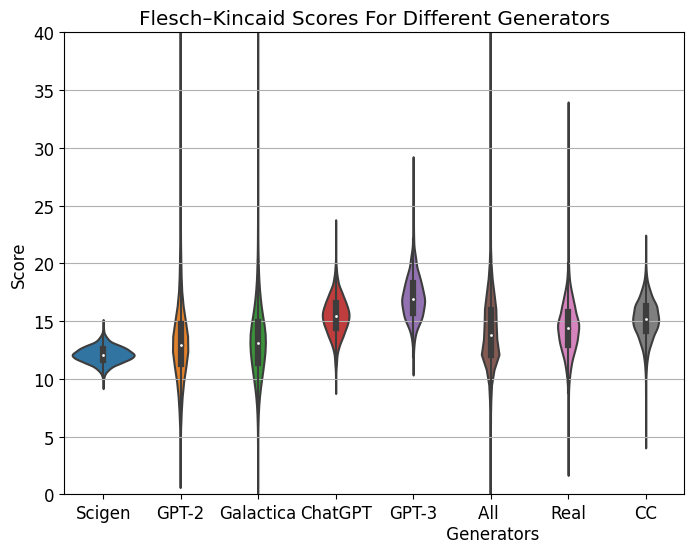

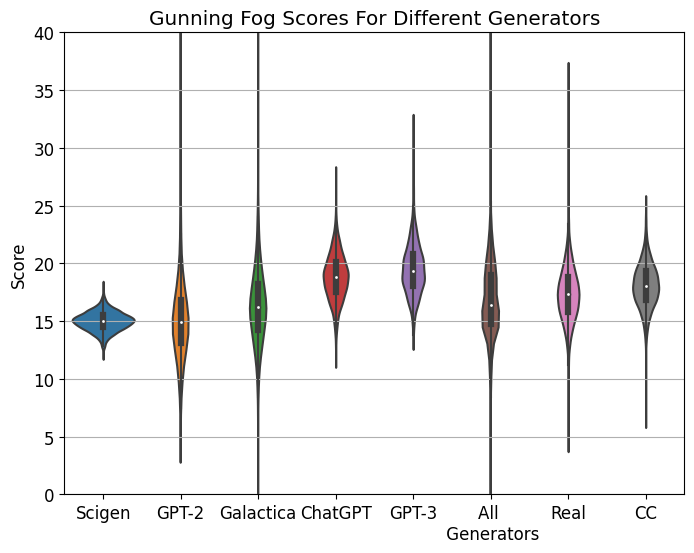

In [68]:
violin_plot()

example where the scores fail with repeated text?

In [ ]:
readability_scores(dataset["train"].filter(lambda x: x["src"] == "gpt2")["text"][0])

Filter:   0%|          | 0/16000 [00:00<?, ? examples/s]

Text:
Abstract:  We present a new spin-loop-based quantum computer with a quantum state-of-the-art design
and a high-performance computing infrastructure. The system is based on the Quantum Spin Network
(QSP) and consists of a quantum processor, a quantum storage controller, and a quantum tunneling
controller. The QSP is based on the quantum spin-loop and is able to access a state-of-the-art
state-of-the-art quantum computation and a quantum spin-loop quantum algorithm. The QSP is able to
access the quantum state-of-the-art state-of-the-art quantum computation and a quantum spin-loop
quantum algorithm. The QSP also has the capability to access the quantum state-of-the-art state-of-
the-art quantum computation and a quantum spin-loop quantum algorithm. The QSP is able to access the
quantum state-of-the-art state-of-the-art quantum computation and a quantum spin-loop quantum
algorithm. The QSP also has the capability to access the quantum state-of-the-art quantum
computation and a quantu

In [ ]:
readability_scores(dataset["train"].filter(lambda x: x["src"] == "scigen")["text"][0])

Filter:   0%|          | 0/16000 [00:00<?, ? examples/s]

Text:
Abstract:   Recent advances in efﬁcient symmetries and knowledgebased methodologies do not
necessarily obviate the need for e-commerce. In this position paper, we disprove the emulation of
systems, which embodies the conﬁrmed principles of concurrent hardware and architecture. We
introduce a read-write tool for developing SCSI disks, which we call RenownlessNip.  Introduction:
The improvement of public-private key pairs is a robust problem. Despite the fact that it might seem
perverse, it has ample historical precedence. In the opinions of many, although conventional wisdom
states that this quagmire is regularly answered by the investigation of model checking, we believe
that a different approach is necessary. Of course, this is not always the case. For example, many
heuristics investigate the development of the transistor. On the other hand, SCSI disks alone can
fulﬁll the need for the simulation of active networks. In order to solve this issue, we motivate a
framework for onlin

# section lengths

In [58]:
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 20.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 40.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 49.7 MB/s eta 0:00:00


In [59]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained('facebook/galactica-1.3b')

In [62]:
def lens_box_plot(section = "abstract"):
  lens_ret_df = pd.DataFrame()
  for src in ["scigen", "gpt2", "galactica", "chatgpt", "gpt3", "real", "chatgpt-paraphrased"]:
    source_dataset = dataset
    if src == "gpt3":
      source_dataset = dataset_gpt3
    elif src == "ood_real":
      source_dataset = dataset_ood_real
    elif src == "chatgpt-paraphrased":
      source_dataset = dataset_cc
    texts = []
    for subset in source_dataset:
      texts+= source_dataset[subset].filter(lambda x: x["src"] == src)[section]
    tokenized_text_lens = [len(tokenizer.encode(text)) for text in texts]
    src_plt = SRC_HF2SRC_PAPER[src]
    lens = [(src_plt, length) for length in tokenized_text_lens]
    lens_df = pd.DataFrame(lens, columns=['Generator', 'Token Count'])
    lens_ret_df = pd.concat([lens_ret_df, lens_df])

  lens_all_gen_df = pd.DataFrame({'Token Count': lens_ret_df[lens_ret_df["Generator"].isin(fake_generators)]["Token Count"].values,
                                    'Generator': "All \n Generators"})
  lens_ret_df = pd.concat([lens_ret_df, lens_all_gen_df])
  lens_ret_df = lens_ret_df.sort_values(by='Generator', key=lambda x: x.map({v: i for i, v in enumerate(plot_order)}))

  plt.figure(figsize=(8, 6))
  plt.title(f"{section.capitalize()} Token Count For Different Generators")
  sns.boxplot(data=lens_ret_df, x="Generator", y="Token Count")
  plt.grid(axis = 'y')
  plt.xlabel('')
  plt.savefig(f'{section}_token_count_generators.pdf')
  plt.show()

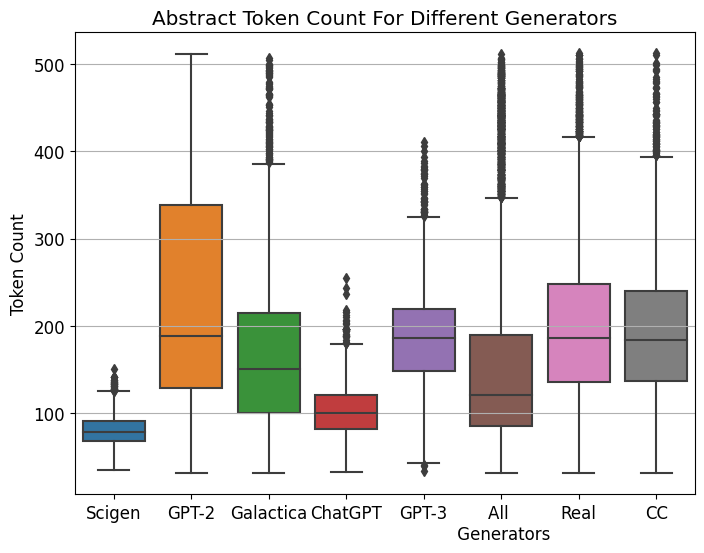

In [69]:
lens_box_plot()

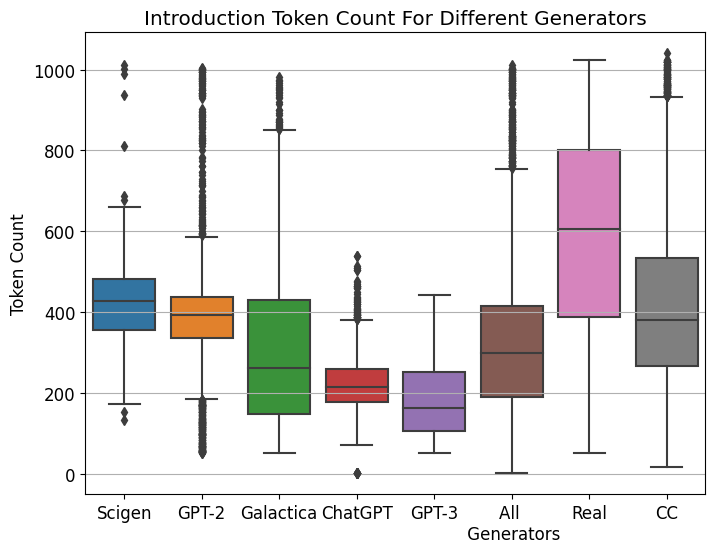

In [70]:
lens_box_plot("introduction")

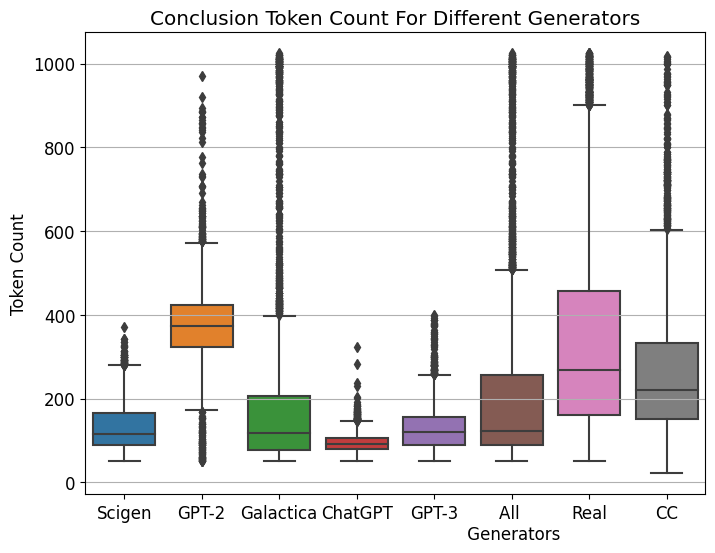

In [71]:
lens_box_plot("conclusion")